# **Load and create datasets - no need to run again**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import cv2
path_for_spectograms = "/content/drive/MyDrive/DL/DuDI2/spectograms"
path_for_waves = "/content/drive/MyDrive/DL/DuDI2/sounds_in_order"
main_path = "/content/drive/MyDrive/DL/DuDI2"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
spectograms_data = []
training_names = []
for img in sorted(os.listdir(path_for_spectograms), key=lambda x: (x.split("-")[0].lower(), int(x.split("-")[1].split(".")[0]))):
    pic = cv2.imread(os.path.join(path_for_spectograms,img))
    spectograms_data.append([pic])
    training_names.append(img)


In [ ]:
waves_data = []
for img in sorted(os.listdir(path_for_waves), key=lambda x: (x.split("-")[0].lower(), int(x.split("-")[1].split(".")[0]))):
    pic = cv2.imread(os.path.join(path_for_waves,img))
    waves_data.append([pic])


**Save data as features**

In [ ]:
np.save(os.path.join(main_path,'waves_features'),np.array(waves_data))
np.save(os.path.join(main_path,'features'),np.array(spectograms_data))


In [ ]:
saved = np.load(os.path.join(main_path,'features.npy'))
saved_waves =  np.load(os.path.join(main_path,'waves_features.npy'))

**Validate data**

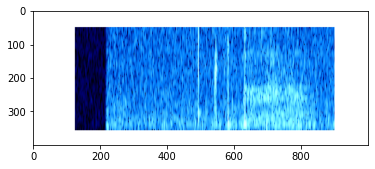

In [ ]:
plt.imshow(saved[0][0].reshape(400,1000,3))


**Arrange and map labels to correct images**

In [ ]:
only_segmentations = pd.read_csv("/content/drive/MyDrive/DL/DuDI2/onlysegmentations.csv",header = None)

In [ ]:
segs_with_filename = pd.read_csv("/content/drive/MyDrive/DL/DuDI2/segmentations.csv",header = None)

In [ ]:
from collections import defaultdict
dic_segs = defaultdict(dict)
for index, row in segs_with_filename.iterrows():
  if "data" in row[0]:
    dic_segs["data"][row[1]] = only_segmentations.loc[index]
  elif "12" not in row[0]:
    dic_segs["0" + row[0].split(".")[0].split("_")[0]][row[1]] = only_segmentations.loc[index]
  else:
    dic_segs[row[0].split(".")[0].split("_")[0]][row[1]] = only_segmentations.loc[index]


In [ ]:
dic_segs.keys()

dict_keys(['data', '00A', '00B', '12A', '04A', '08A', '08B', '09A'])

In [ ]:
new_segs = pd.DataFrame(columns=[i for i in range(1000)])

In [ ]:
for name in training_names:
  file_name = name.split(".")[0]
  if "data" not in name:
      file_name = file_name.split("_")[0][-3:]

  second = name.split("-")[1].split(".")[0]

  new_segs = new_segs.append(dic_segs[file_name][int(second)])

In [ ]:
new_segs.to_csv(os.path.join(main_path,'ordered_segs.csv'))

******************************************************************
##                           Start Here for both models!
******************************************************************


**Load data**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from PIL import Image
import cv2
import gc

main_path = "/content/drive/MyDrive/DL/DuDI2"
spectograms = np.load(os.path.join(main_path,'features.npy'))
waves = np.load(os.path.join(main_path,'waves_features.npy'))

segmentations = pd.read_csv(os.path.join(main_path,'ordered_segs.csv'))
segs_without_first = segmentations.iloc[: , 1:].astype('int64')
np_segs = segs_without_first.to_numpy()



**Transform data to tensor and create data loaders**

In [7]:
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
#spectograms
X_spec = torch.from_numpy(spectograms)
X_spec = X_spec.squeeze(1)
X_spec = X_spec.transpose(1,3)#.to("cuda")


In [8]:
#waves
X_wave = torch.from_numpy(waves)
X_wave = X_wave.squeeze(1)
X_wave = X_wave.transpose(1,3)#.to("cuda")


**Stack spectograms and waves together**

In [9]:
X = torch.stack((X_spec,X_wave),dim=1)

**Join similar/unused segments**

In [4]:
np_segs[np_segs == 593] = 97 # a and ɑ
np_segs[np_segs == 120] = 967 # χ and x
np_segs[np_segs == 114] = 641 # ʁ and r
np_segs[np_segs == 609] = 103 # g and ɡ



**Create classes**

In [5]:
classes = set()
for row in np_segs:
  classes = classes.union(set(row))


# **Pre-process labels - for segmentation net**

 For groups net - please go down

**Map class to index, for CEL**

In [ ]:
n_classes = len(classes)
classes = sorted(list(classes))
cls_to_idx = {}
idx_to_cls = {}
for i, cls in enumerate(classes):
  cls_to_idx[cls] = i
  idx_to_cls[i] = cls


**Defining segments attributes for statistics**

In [ ]:
from collections import defaultdict

#manner of articulation:
empty = ({32},"empty") # no speech
vowels = ({97,101,105,111,117},"vowels")
plosives = ({98,112,116,100,609,107,660,103},"plosives")
nasals = ({109,110}, "nasals")
fricatives = ({102,115,122,643,104,967,118,641},"frictatives")
approximents = ({106},"approximents")
laterals = ({108},"laterals")
affircates = ({678,679},"affricates")

opts = [empty,vowels,plosives,nasals,fricatives,approximents,laterals,affircates]
groups = defaultdict(set)
segment_to_group = {}
for cls in classes:
  for opt in opts:
    if cls in opt[0]:
      groups[opt[1]].add(cls)
      segment_to_group[cls] = opt[1] 




In [ ]:
#voicing:
voiced = {98,109,118,100,122,103,641,106}
voiceless = set(classes) - voiced
#place of articulation:
bilabial = {98,112,109}
labio_dental = {102,118}
alveolar = {116,199,110,115,122,678,679}
palatal = {106}
velar = {107,103}
uvular = {967,641}
glotal = {104,660}
post_alveolar = {643}
nothing = {32}
places = [bilabial,labio_dental,alveolar,palatal,velar,uvular,glotal,post_alveolar]


In [ ]:
class Segment:

  def __init__(self,ind,voiced, group, place):
    self.ind = ind
    self.voiced = voiced
    self.group = group
    self.place = place


In [ ]:
def is_voiced(cls):
  return cls in voiced
def get_place(cls):
  for i,place in enumerate(places):
    if cls in place:
      return i

segments = []
for cls in classes:
  segment = Segment(cls,is_voiced(cls),segment_to_group[cls],get_place(cls))
  segments.append(segment)

cls_to_segment = {}
for seg in segments:
  cls_to_segment[seg.ind] = seg
     

**Map each class to an index**

In [27]:
Y = torch.from_numpy(np_segs)
Y.apply_(lambda x:cls_to_idx[x])
Y.to("cuda")

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  8,  8,  8],
        [ 8,  8,  8,  ..., 14, 14, 14],
        ...,
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0]], device='cuda:0')

**Remove Zeros - ron only if needed** 

In [ ]:
from tqdm import tqdm
new_X = []
new_Y = []
for i in tqdm(range(len(Y))):
  row = Y[i]
  if sum(row)!=0:
    new_Y.append(row)
    new_X.append(X[i])


100%|██████████| 3574/3574 [00:11<00:00, 324.59it/s]


In [ ]:
del(X)
del(Y)

In [ ]:
Y = torch.cat(new_Y,dim=-1)


In [ ]:
Y = Y.view(2877,1000)

In [ ]:
X = torch.cat(new_X)

In [ ]:
X = X.view(2877,2,3,1000,400)

In [ ]:
X.shape

torch.Size([2877, 2, 3, 1000, 400])

In [ ]:
Y.to("cuda")

tensor([[ 0,  0,  0,  ...,  8,  8,  8],
        [ 8,  8,  8,  ..., 14, 14, 14],
        [14, 14, 14,  ...,  0,  0,  0],
        ...,
        [26, 26, 26,  ...,  4,  4,  4],
        [ 4,  4,  4,  ..., 14, 14, 14],
        [14, 14, 14,  ...,  0,  0,  0]], device='cuda:0')

**done with zero removal**

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

**Split to train and test**

In [ ]:
from sklearn.model_selection import train_test_split
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    Y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(X_train,y_train)
datatset_test = TensorDataset(X_test,y_test)

In [ ]:
batch_size = 4
dataload = DataLoader(dataset, batch_size=batch_size)
test_dataload = DataLoader(datatset_test, batch_size=batch_size)

# **The Net**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# with waves - to use
class DuNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,7,(25,5),stride = (7,3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 12, (10,5), stride=(2,2))
        self.conv3 = nn.Conv2d(12, 30, 5)

        self.fc1 = nn.Linear( 1500, 3500)
        self.fc2 = nn.Linear(3500, 6000)
        self.fc3 = nn.Linear(6000, n_classes*1000)

    def forward(self, x):
        x_s = x[:,0,:,:]
        x_s = self.pool(F.relu(self.conv1(x_s)))
        x_s = self.pool(F.relu(self.conv2(x_s)))
        x_s = self.pool(F.relu(self.conv3(x_s)))
        
        x_w = x[:,1,:,:]
        x_w = self.pool(F.relu(self.conv1(x_w)))
        x_w = self.pool(F.relu(self.conv2(x_w)))
        x_w = self.pool(F.relu(self.conv3(x_w)))

        x_s = torch.flatten(x_s, 1)
        x_w = torch.flatten(x_w, 1)  
        #concat waves and spectograms              
        x = torch.cat((x_s, x_w),1).to("cuda")        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#for one image instead of two
# class DuNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3,16,(25,5),stride = (7,3))
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(16, 10, (10,5), stride=(2,2))
#         self.conv3 = nn.Conv2d(10, 25, 5)

#         self.fc1 = nn.Linear(625, 2000)
#         self.fc2 = nn.Linear(2000,3000)
#         self.fc3 = nn.Linear(3000, 1500)
#         self.fc4 = nn.Linear(1500, n_classes*1000)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x

# regular
# class DuNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3,6,(25,5),stride = (7,3))
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 10, (10,5), stride=(2,2))
#         self.conv3 = nn.Conv2d(10, 16, 5)

#         self.fc1 = nn.Linear(400, 2000)
#         self.fc2 = nn.Linear(2000, 1500)
#         self.fc3 = nn.Linear(1500, n_classes*1000)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = self.pool(F.relu(self.conv3(x)))
#         x = torch.flatten(x, 1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x






In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()

net = DuNet()
net.to("cuda")


DuNet(
  (conv1): Conv2d(3, 7, kernel_size=(25, 5), stride=(7, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(7, 12, kernel_size=(10, 5), stride=(2, 2))
  (conv3): Conv2d(12, 30, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1500, out_features=3500, bias=True)
  (fc2): Linear(in_features=3500, out_features=6000, bias=True)
  (fc3): Linear(in_features=6000, out_features=27000, bias=True)
)

**Define weights for cross entropy loss**

In [ ]:
w = [10] +[50]*(n_classes-1)
w = torch.tensor(w).to("cuda").float()


**Parameters and fine tuning**

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss(weight=w)
optimizer = optim.Adam(net.parameters(), lr=2e-5) 


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()


132

**Train loop**

  0%|          | 0/50 [00:00<?, ?it/s]

[1,   200] loss: 2.830


  2%|▏         | 1/50 [00:10<08:37, 10.56s/it]

[2,   200] loss: 2.599


  4%|▍         | 2/50 [00:20<08:22, 10.48s/it]

[3,   200] loss: 2.420


  6%|▌         | 3/50 [00:31<08:11, 10.46s/it]

[4,   200] loss: 2.208


  8%|▊         | 4/50 [00:41<08:00, 10.44s/it]

[5,   200] loss: 1.986


 10%|█         | 5/50 [00:52<07:49, 10.44s/it]

[6,   200] loss: 1.769


 12%|█▏        | 6/50 [01:02<07:39, 10.44s/it]

[7,   200] loss: 1.557


 14%|█▍        | 7/50 [01:13<07:28, 10.43s/it]

[8,   200] loss: 1.347


 16%|█▌        | 8/50 [01:23<07:18, 10.43s/it]

[9,   200] loss: 1.143


 18%|█▊        | 9/50 [01:33<07:07, 10.42s/it]

[10,   200] loss: 0.953


 20%|██        | 10/50 [01:44<06:58, 10.45s/it]

[11,   200] loss: 0.786


 22%|██▏       | 11/50 [01:54<06:47, 10.46s/it]

[12,   200] loss: 0.644


 24%|██▍       | 12/50 [02:05<06:36, 10.45s/it]

[13,   200] loss: 0.530


 26%|██▌       | 13/50 [02:15<06:26, 10.44s/it]

[14,   200] loss: 0.433


 28%|██▊       | 14/50 [02:26<06:15, 10.44s/it]

[15,   200] loss: 0.339


 30%|███       | 15/50 [02:36<06:05, 10.44s/it]

[16,   200] loss: 0.270


 32%|███▏      | 16/50 [02:47<05:54, 10.44s/it]

[17,   200] loss: 0.224


 34%|███▍      | 17/50 [02:57<05:44, 10.44s/it]

[18,   200] loss: 0.185


 36%|███▌      | 18/50 [03:07<05:33, 10.43s/it]

[19,   200] loss: 0.155


 38%|███▊      | 19/50 [03:18<05:23, 10.44s/it]

[20,   200] loss: 0.131


 40%|████      | 20/50 [03:28<05:13, 10.45s/it]

[21,   200] loss: 0.100


 42%|████▏     | 21/50 [03:39<05:04, 10.51s/it]

[22,   200] loss: 0.078


 44%|████▍     | 22/50 [03:50<04:55, 10.55s/it]

[23,   200] loss: 0.055


 46%|████▌     | 23/50 [04:00<04:45, 10.57s/it]

[24,   200] loss: 0.041


 48%|████▊     | 24/50 [04:11<04:35, 10.58s/it]

[25,   200] loss: 0.030


 50%|█████     | 25/50 [04:21<04:24, 10.58s/it]

[26,   200] loss: 0.024


 52%|█████▏    | 26/50 [04:32<04:14, 10.60s/it]

[27,   200] loss: 0.021


 54%|█████▍    | 27/50 [04:43<04:04, 10.63s/it]

[28,   200] loss: 0.019


 56%|█████▌    | 28/50 [04:53<03:53, 10.63s/it]

[29,   200] loss: 0.017


 58%|█████▊    | 29/50 [05:04<03:43, 10.62s/it]

[30,   200] loss: 0.015


 60%|██████    | 30/50 [05:15<03:32, 10.63s/it]

[31,   200] loss: 0.011


 62%|██████▏   | 31/50 [05:25<03:22, 10.64s/it]

[32,   200] loss: 0.010


 64%|██████▍   | 32/50 [05:36<03:11, 10.66s/it]

[33,   200] loss: 0.011


 66%|██████▌   | 33/50 [05:47<03:01, 10.65s/it]

[34,   200] loss: 0.014


 68%|██████▊   | 34/50 [05:57<02:50, 10.66s/it]

[35,   200] loss: 0.014


 70%|███████   | 35/50 [06:08<02:39, 10.63s/it]

[36,   200] loss: 0.007


 72%|███████▏  | 36/50 [06:19<02:28, 10.62s/it]

[37,   200] loss: 0.004


 74%|███████▍  | 37/50 [06:29<02:18, 10.62s/it]

[38,   200] loss: 0.002


 76%|███████▌  | 38/50 [06:40<02:07, 10.63s/it]

[39,   200] loss: 0.002


 78%|███████▊  | 39/50 [06:51<01:57, 10.66s/it]

[40,   200] loss: 0.003


 80%|████████  | 40/50 [07:01<01:46, 10.65s/it]

[41,   200] loss: 0.042


 82%|████████▏ | 41/50 [07:12<01:35, 10.66s/it]

[42,   200] loss: 0.009


 84%|████████▍ | 42/50 [07:23<01:25, 10.66s/it]

[43,   200] loss: 0.003


 86%|████████▌ | 43/50 [07:33<01:14, 10.66s/it]

[44,   200] loss: 0.001


 88%|████████▊ | 44/50 [07:44<01:03, 10.64s/it]

[45,   200] loss: 0.001


 90%|█████████ | 45/50 [07:54<00:53, 10.63s/it]

[46,   200] loss: 0.001


 92%|█████████▏| 46/50 [08:05<00:42, 10.61s/it]

[47,   200] loss: 0.001


 94%|█████████▍| 47/50 [08:16<00:31, 10.61s/it]

[48,   200] loss: 0.018


 96%|█████████▌| 48/50 [08:26<00:21, 10.61s/it]

[49,   200] loss: 0.012


 98%|█████████▊| 49/50 [08:37<00:10, 10.61s/it]

[50,   200] loss: 0.004


100%|██████████| 50/50 [08:47<00:00, 10.56s/it]

Finished Training


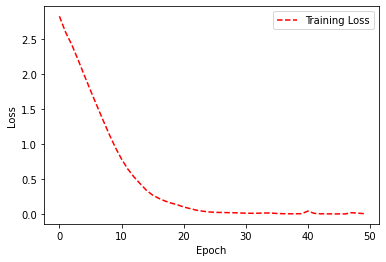

In [ ]:
from tqdm import tqdm


net.train()
training_loss = []
for epoch in tqdm(range(100)):  
    running_loss = 0.0
    for i, data in enumerate(dataload, 0):
        inputs, labels = data
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to("cuda").float())
        outputs = outputs.view(-1,n_classes,1000).to("cuda")
        loss = criterion(outputs, labels.to("cuda"))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            training_loss.append(running_loss / 200)
            running_loss = 0.0

print('Finished Training')

plt.plot([i for i in range(50)], training_loss, 'r--')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();



**Save/Load net parameters**

In [ ]:
# run only if needed!!
# PATH = "/content/drive/MyDrive/DL/DuDI2/Dudi2_without_zeros_net.pth"

# torch.save(net.state_dict(), PATH)

In [ ]:
# PATH = "/content/drive/MyDrive/DL/DuDI2/Dudi2_net.pth"

# net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

**Evaluation**

In [ ]:
net.eval()


DuNet(
  (conv1): Conv2d(3, 7, kernel_size=(25, 5), stride=(7, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(7, 12, kernel_size=(10, 5), stride=(2, 2))
  (conv3): Conv2d(12, 30, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1500, out_features=3500, bias=True)
  (fc2): Linear(in_features=3500, out_features=6000, bias=True)
  (fc3): Linear(in_features=6000, out_features=27000, bias=True)
)

In [ ]:
from tqdm import tqdm
from collections import Counter
total_accuracy = 0
not_zero_acc = 0
goods = set()
with_letters = 0
number_of_zeros = 0
good_on_zero = 0
all_not_zeros = 0
mistake_on_not_zero = 0
group_is_correct = 0
group_not_zero_correct = 0
voiced_accuracy = 0
manner_accuracy = 0
acc_all = 0
partial = 0
for j in tqdm(range(len(X_test))):

  cnt = 0
  total_not_zero_count = 0
  cnt_not_zero = 0
  true = y_test[j]
  predicted = torch.argmax(net(X_test[j].to("cuda").unsqueeze(0).float()).view(n_classes,1000),axis=0) 
  cnt_true = Counter([t.item() for t in true])
  cnt_pred = Counter([t.item() for t in predicted])
  true_len = len(cnt_true)
  commons = cnt_pred.most_common(true_len)
  inter = set([c[0] for c in commons]).intersection(set([ k for k in cnt_true.keys()]))
  acc_all += len(inter)/true_len
  partial += sum([cnt_pred[p] for p in inter])/1000
  for i in range(1000):
    if segment_to_group[idx_to_cls[true[i].item()]] == segment_to_group[idx_to_cls[predicted[i].item()]]:
      group_is_correct += 1
      if true[i].item() != 0:
        group_not_zero_correct +=1
    if cls_to_segment[idx_to_cls[true[i].item()]].voiced == cls_to_segment[idx_to_cls[predicted[i].item()]].voiced:
      voiced_accuracy +=1
    if cls_to_segment[idx_to_cls[true[i].item()]].place == cls_to_segment[idx_to_cls[predicted[i].item()]].place:
      manner_accuracy +=1

    if true[i]==0:
      number_of_zeros +=1
      if predicted[i]==0:
        good_on_zero +=1 
    if true[i] != 0:
      all_not_zeros += 1
      total_not_zero_count+=1
      if predicted[i] == 0:
          mistake_on_not_zero +=1
    if true[i].item() == predicted[i].item() :
      cnt += 1
      if true[i] != 0:
        cnt_not_zero += 1
        goods.add(true[i].item())
          
  total_accuracy += (cnt/1000)
  if total_not_zero_count:
    with_letters += 1
    not_zero_acc += (cnt_not_zero / total_not_zero_count)

print("\n total accuracy: ",total_accuracy/len(X_test))
print("accuracy of letters: ",not_zero_acc/with_letters)
print("predicted zero when true is zero: ",good_on_zero/number_of_zeros)
print("predicted  zero when true is  not zero: ",mistake_on_not_zero/all_not_zeros)
print("accuracy of groups: ", group_is_correct/(len(X_test)*1000))
print("accuracy of groups not including zero: ", group_not_zero_correct/(len(X_test)*1000 - number_of_zeros ))
print("voiced accuracy: ",voiced_accuracy/(len(X_test)*1000))
print("place accuracy: ",manner_accuracy/(len(X_test)*1000))
print("accuracy of intersection of segments: ", acc_all/len(X_test))
print("volume of intersection:", partial/len(X_test))

100%|██████████| 576/576 [01:22<00:00,  6.98it/s]


 total accuracy:  0.4545225694444446
accuracy of letters:  0.31264971322768736
predicted zero when true is zero:  0.7470926888588222
predicted  zero when true is  not zero:  0.09419407639734345
accuracy of groups:  0.5895642361111111
accuracy of groups not including zero:  0.5164712550483805
voiced accuracy:  0.8421475694444445
place accuracy:  0.6564479166666667
accuracy of intersection of segments:  0.627741037897288
volume of intersection: 0.7385694444444447


# **Groups net starts here**

**Pre-process labels**

In [ ]:
groups_dict = {"empty":0,"vowels":1,"plosives":2,"frictatives":3,"affricates":4,"sonorants":5}

In [ ]:
n_classes = len(groups_dict)
classes = sorted(list(classes))

In [ ]:
from collections import defaultdict
empty = ({32},"empty")
vowels = ({97,101,105,111,117},"vowels")
plosives = ({98,112,116,100,609,107,660,103},"plosives")
nasals = ({109,110}, "nasals")
fricatives = ({102,115,122,643,104,967,118,641},"frictatives")
approximents = ({106},"approximents")
laterals = ({108},"laterals")
affircates = ({678,679},"affricates")
sonorants = ({106,108,109,110},"sonorants")
opts = [empty,vowels,plosives,fricatives,affircates,sonorants]
groups = defaultdict(set)
segment_to_group = {}
for cls in classes:
  for opt in opts:
    if cls in opt[0]:
      groups[opt[1]].add(cls)
      segment_to_group[cls] = opt[1] 




**Map groups to index**

In [ ]:
Y_groups = torch.from_numpy(np_segs)
Y_groups.apply_(lambda x:groups_dict[segment_to_group[x]])
Y_groups.to("cuda")


tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()


In [ ]:
from sklearn.model_selection import train_test_split
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    Y_groups, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
dataset = TensorDataset(X_train,y_train)
datatset_test = TensorDataset(X_test,y_test)

In [ ]:
batch_size = 8
dataload = DataLoader(dataset, batch_size=batch_size)
test_dataload = DataLoader(datatset_test, batch_size=batch_size)


**The Net**

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class GroupsNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,7,(25,5),stride = (7,3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 12, (10,5), stride=(2,2))
        self.conv3 = nn.Conv2d(12, 30, 5)

        self.fc1 = nn.Linear( 1500,3000 )
        self.fc2 = nn.Linear(3000, 5000)
        self.fc3 = nn.Linear(5000, n_classes*1000)

    def forward(self, x):
        x_s = x[:,0,:,:]
        x_s = self.pool(F.relu(self.conv1(x_s)))
        x_s = self.pool(F.relu(self.conv2(x_s)))
        x_s = self.pool(F.relu(self.conv3(x_s)))
        
        x_w = x[:,1,:,:]
        x_w = self.pool(F.relu(self.conv1(x_w)))
        x_w = self.pool(F.relu(self.conv2(x_w)))
        x_w = self.pool(F.relu(self.conv3(x_w)))

        x_s = torch.flatten(x_s, 1)
        x_w = torch.flatten(x_w, 1)                
        x = torch.cat((x_s, x_w),1).to("cuda")        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x




In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
groupNet = GroupsNet()
groupNet.to("cuda")


GroupsNet(
  (conv1): Conv2d(3, 7, kernel_size=(25, 5), stride=(7, 3))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(7, 12, kernel_size=(10, 5), stride=(2, 2))
  (conv3): Conv2d(12, 30, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1500, out_features=3000, bias=True)
  (fc2): Linear(in_features=3000, out_features=5000, bias=True)
  (fc3): Linear(in_features=5000, out_features=6000, bias=True)
)

**Weights, parameters and fine tuining**

In [ ]:
w = [10] +[30]*(n_classes-1)
w = torch.tensor(w).to("cuda").float()


In [ ]:
import torch.optim as optim
criterion_groups = nn.CrossEntropyLoss(weight=w)
optimizer_groups = optim.Adam(groupNet.parameters(), lr=1e-5)


In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()


132

**Train loop**

In [ ]:
from tqdm import tqdm

groupNet.train()
for epoch in tqdm(range(100)):  
    running_loss = 0.0
    for i, data in enumerate(dataload, 0):
        inputs, labels = data
        optimizer_groups.zero_grad()

        # forward + backward + optimize
        outputs = groupNet(inputs.to("cuda").float())
        outputs = outputs.view(-1,n_classes,1000).to("cuda")
        loss = criterion_groups(outputs, labels.to("cuda"))
        loss.backward()
        optimizer_groups.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')


**Evaluation**

In [ ]:
groupNet.eval()
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from collections import Counter
correct = 0
not_empty = 0
correct_letters = 0
vow = 0
vow_cor = 0
plos = 0
plos_cor = 0
fri = 0
fri_cor = 0
aff = 0
aff_cor =0
son = 0
son_cor = 0
for j in tqdm(range(len(X_test))):
  true = y_test[j]
  # true = y_test[:,0][j]
  predicted = torch.argmax(groupNet(X_test[j].to("cuda").unsqueeze(0).float()).view(n_classes,1000),axis=0) 
  
  for i in range(1000):
    if true[i].item() != 0:
      not_empty +=1
      if true[i].item()==1:
        vow +=1
      elif true[i].item()==2:
        plos +=1
      elif true[i].item()==3:
        fri +=1
      elif true[i].item()==4:
        aff +=1
      elif true[i].item()==5:
        son +=1
    if true[i].item() == predicted[i].item():
      correct += 1
      if true[i] != 0:
        correct_letters += 1
        if true[i].item()==1:
          vow_cor +=1
        elif true[i].item()==2:
          plos_cor +=1
        elif true[i].item()==3:
          fri_cor +=1
        elif true[i].item()==4:
          aff_cor +=1
        elif true[i].item()==5:
          son_cor +=1

        
          
print("\n total accuracy is: ",correct/(len(X_test)*1000))
print("accuracy of letters groups is: ",correct_letters/not_empty)
print("acc of vowels: ",vow_cor/vow, " (",vow,")")
print("acc of plosives: ",plos_cor/plos, " (",plos,")")
print("acc of fricatives: ",fri_cor/fri, " (",fri,")")
print("acc of sonorants: ",son_cor/son, " (",son,")")
print("acc of affricates: ",aff_cor/aff, " (",aff,")")

100%|██████████| 715/715 [00:30<00:00, 23.68it/s]


 total accuracy is:  0.6416951048951048
accuracy of letters groups is:  0.5580189356083587
acc of vowels:  0.7391659615617068  ( 206825 )
acc of plosives:  0.4257585644371941  ( 61300 )
acc of fricatives:  0.43165930831493743  ( 65232 )
acc of sonorants:  0.24605345885231694  ( 58849 )
acc of affricates:  0.010526315789473684  ( 5035 )


**Save/Load net parameters**

In [ ]:
# run only if needed!!
# PATH_groups_net = "/content/drive/MyDrive/DL/DuDI2/Groupsnet.pth"

# torch.save(groupNet.state_dict(), PATH_groups_net)

In [ ]:
# PATH_groups_net = "/content/drive/MyDrive/DL/DuDI2/Groupsnet.pth"

# net.load_state_dict(torch.load(PATH_groups_net))


<All keys matched successfully>

# **Demo**

In [17]:
import torch.nn as nn
import torch.nn.functional as F
class DuNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,7,(25,5),stride = (7,3))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(7, 12, (10,5), stride=(2,2))
        self.conv3 = nn.Conv2d(12, 30, 5)

        self.fc1 = nn.Linear( 1500, 3500)
        self.fc2 = nn.Linear(3500, 6000)
        self.fc3 = nn.Linear(6000, n_classes*1000)

    def forward(self, x):
        x_s = x[:,0,:,:]
        x_s = self.pool(F.relu(self.conv1(x_s)))
        x_s = self.pool(F.relu(self.conv2(x_s)))
        x_s = self.pool(F.relu(self.conv3(x_s)))
        
        x_w = x[:,1,:,:]
        x_w = self.pool(F.relu(self.conv1(x_w)))
        x_w = self.pool(F.relu(self.conv2(x_w)))
        x_w = self.pool(F.relu(self.conv3(x_w)))

        x_s = torch.flatten(x_s, 1)
        x_w = torch.flatten(x_w, 1)  
        #concat waves and spectograms              
        x = torch.cat((x_s, x_w),1).to("cuda")        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

classes = {641, 643, 967, 660, 32, 97, 98, 100, 101, 678, 679, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 115, 116, 117, 118, 122}
n_classes = len(classes)
classes = sorted(list(classes))
cls_to_idx = {}
idx_to_cls = {}
for i, cls in enumerate(classes):
  cls_to_idx[cls] = i
  idx_to_cls[i] = cls




In [ ]:
!gdown --id 1O222epWvVq82W2WDaj_Duyj63Sj_gQh6


In [43]:

net = DuNet()
net.to("cuda")
net.load_state_dict(torch.load("/content/Dudi2_without_zeros_net.pth"))



<All keys matched successfully>

In [22]:
def predict(wave_and_spec):
  prediction = torch.argmax(net(wave_and_spec.to("cuda").unsqueeze(0).float()).view(n_classes,1000),axis=0) 
  return prediction

**Demo Image**

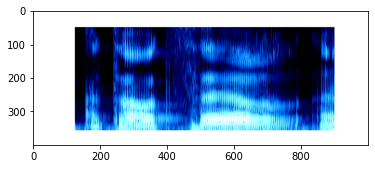

In [39]:
!gdown --id 1MgGDrrOnIKiyNxmT3zlgzHaVY4sbB_W4
!gdown --id 1--5C3pDNXc8Y9PlTISh-NxSECfjz-eEv
t =  torch.load("/content/img_torch.pt")
y = torch.load("/content/labels.pt")

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MgGDrrOnIKiyNxmT3zlgzHaVY4sbB_W4
To: /content/img_torch.pt
100% 8.58G/8.58G [00:36<00:00, 233MB/s]


In [44]:
from collections import Counter
p = predict(t)
cnt_pred = Counter([l.item() for l in p])
cnt_true = Counter([l_2.item() for l_2 in y])
len_true = len(cnt_true)
commons = cnt_pred.most_common(len_true)
segments = set([c[0] for c in commons])
true = set([c for c in cnt_true.keys()])
print("predicted segments:")
for s in segments:
  print(chr(idx_to_cls[s]),end =",")
print("\n true segments:")
for s in true:
  print(chr(idx_to_cls[s]),end =",")



predicted segments:
 ,a,e,t,ʁ,ʦ,
 true segments:
 ,a,e,t,ʁ,ʦ,